In [1]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [2]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [3]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [4]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [5]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [6]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0, st="f(0, 0..., 0)"):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f"Theoretical value ({function_name}):{st} = {c}\n")
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [7]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [8]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.0905173  -0.04242083]
The function value of pqbest:		1.937288658283613
Algorithm running time:			0.046000003814697266 s


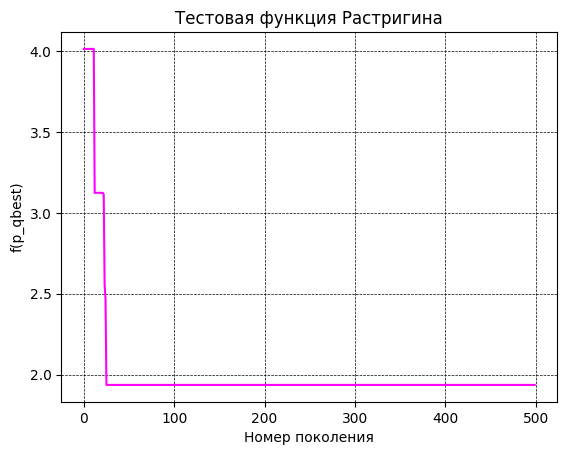

------------------------TEST NUMBER: 2------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.00639838 -0.98857757]
The function value of pqbest:		1.0111496084242972
Algorithm running time:			0.04799628257751465 s


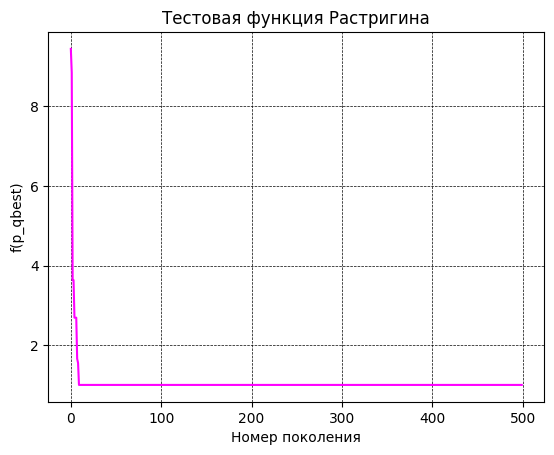

------------------------TEST NUMBER: 3------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-1.01593286 -0.01510926]
The function value of pqbest:		1.1274440214063262
Algorithm running time:			0.04500007629394531 s


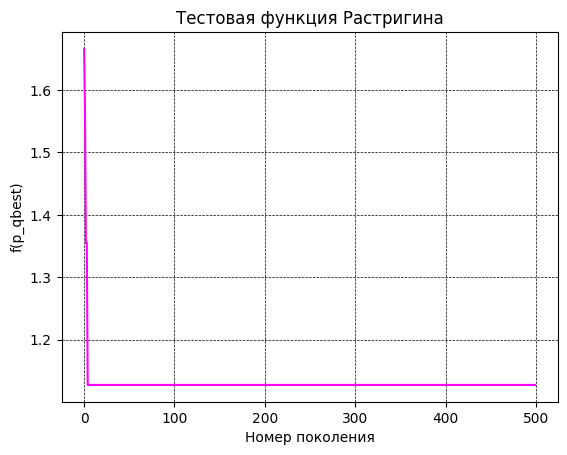

------------------------TEST NUMBER: 4------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.99771109  0.00906447]
The function value of pqbest:		1.0127579909013775
Algorithm running time:			0.04399895668029785 s


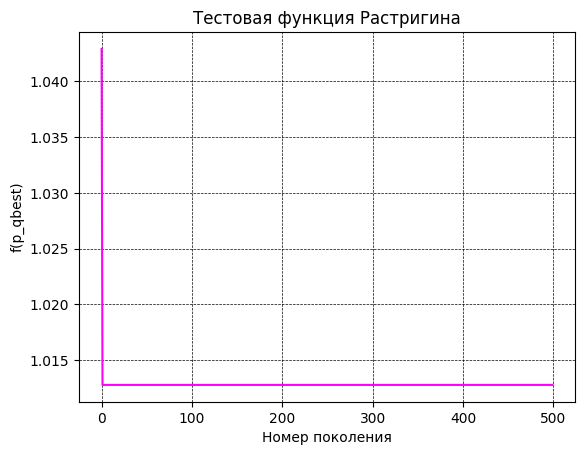

------------------------TEST NUMBER: 5------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.03948601 -0.04833265]
The function value of pqbest:		0.7676665593672496
Algorithm running time:			0.04399919509887695 s


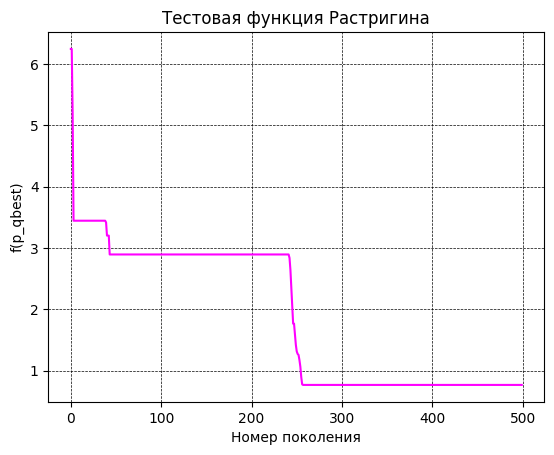

------------------------TEST NUMBER: 6------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.00911049  1.00921565]
The function value of pqbest:		1.051737981205111
Algorithm running time:			0.046000003814697266 s


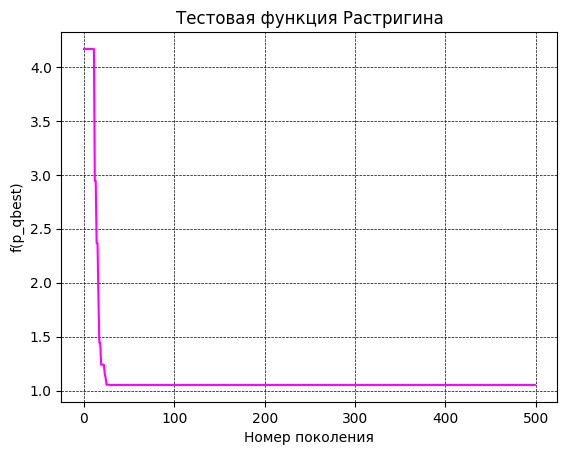

------------------------TEST NUMBER: 7------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.00397591 -0.00467452]
The function value of pqbest:		0.007470779707823283
Algorithm running time:			0.04500865936279297 s


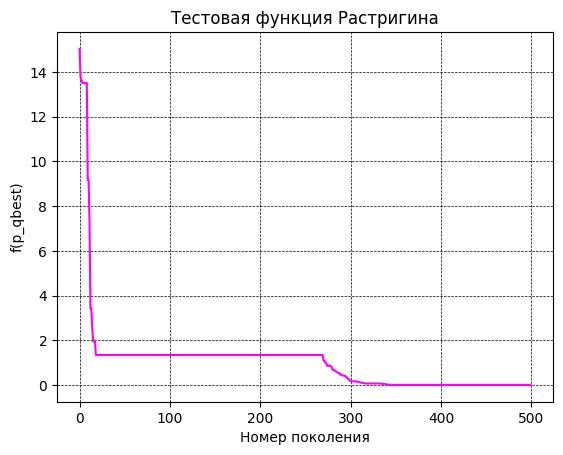

------------------------TEST NUMBER: 8------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[1.0120418  0.03973722]
The function value of pqbest:		1.3644923631516832
Algorithm running time:			0.04400038719177246 s


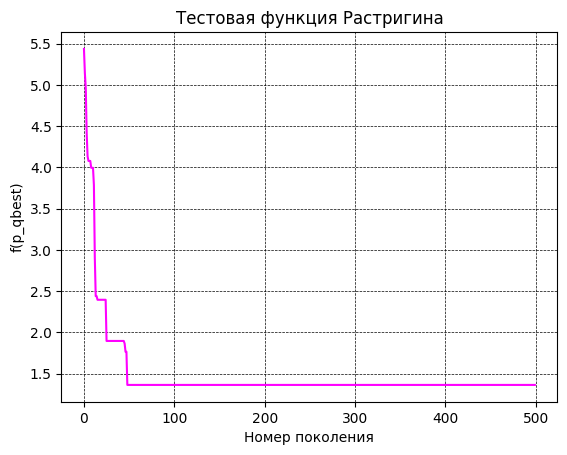

------------------------TEST NUMBER: 9------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[ 0.00757166 -0.91158599]
The function value of pqbest:		2.3461060654896855
Algorithm running time:			0.04399275779724121 s


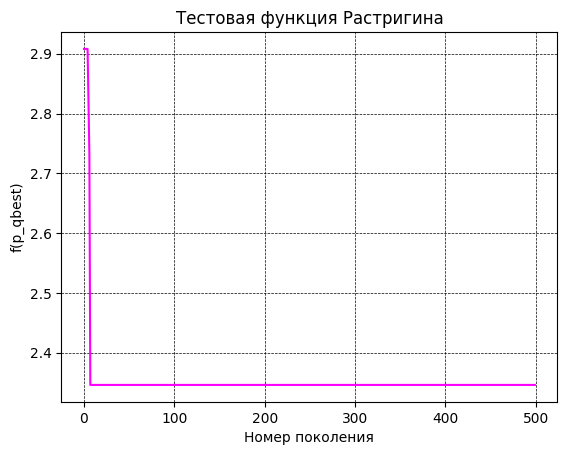

------------------------TEST NUMBER: 10------------------------
Theoretical value (Растригина):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.0156119  1.04623907]
The function value of pqbest:		1.5620062831195867
Algorithm running time:			0.04599595069885254 s


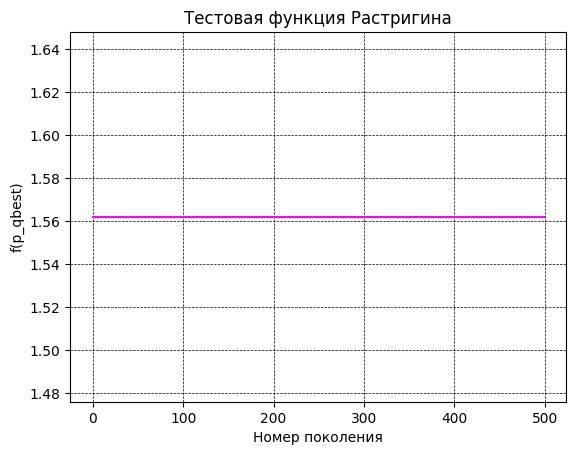

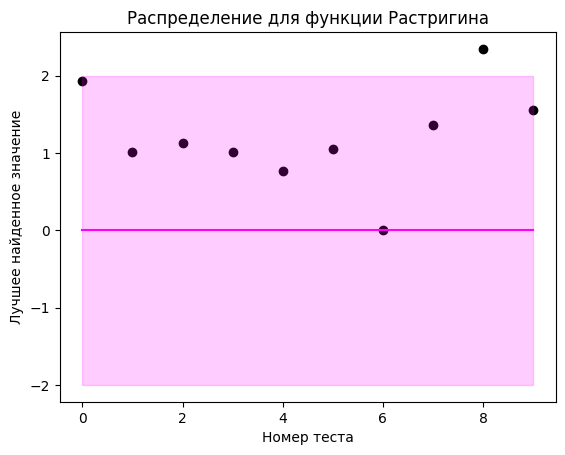

In [32]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [10]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [11]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.00128674 -0.00887142]
The function value of pqbest:		0.02749314864594865
Algorithm running time:			0.04906415939331055 s


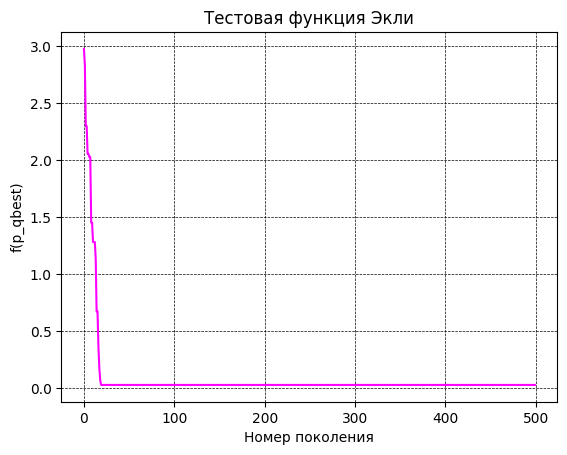

------------------------TEST NUMBER: 2------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[0.18248925 0.11910366]
The function value of pqbest:		1.5530935619898543
Algorithm running time:			0.048979759216308594 s


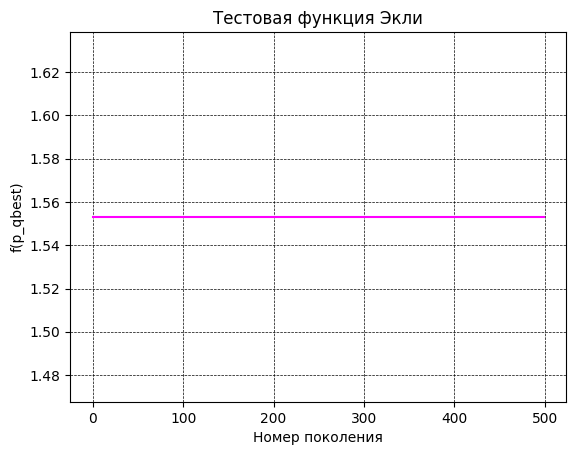

------------------------TEST NUMBER: 3------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[ 0.09936724 -0.1372994 ]
The function value of pqbest:		1.1150562199216907
Algorithm running time:			0.06300497055053711 s


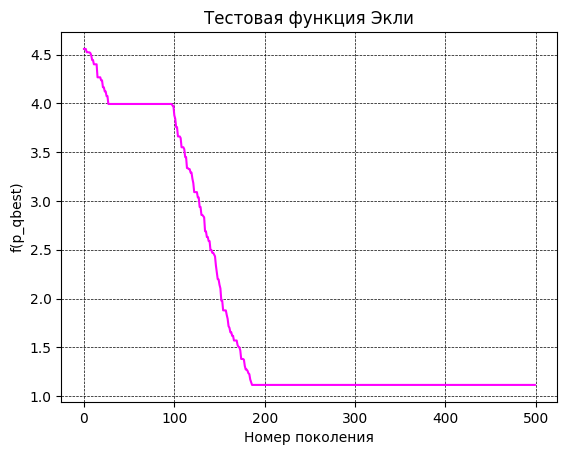

------------------------TEST NUMBER: 4------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[0.1612001 0.1584741]
The function value of pqbest:		1.637237752318832
Algorithm running time:			0.058989524841308594 s


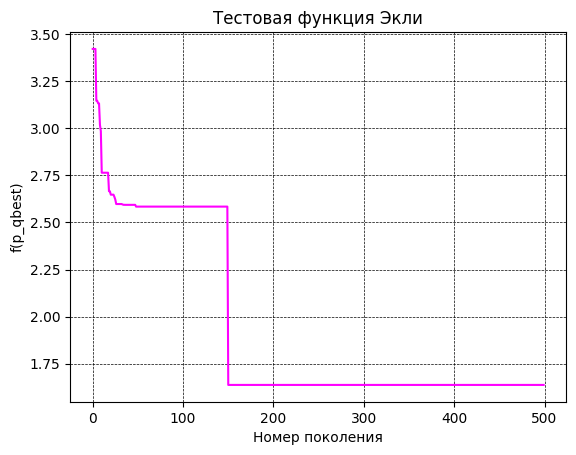

------------------------TEST NUMBER: 5------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.93335701  0.00143672]
The function value of pqbest:		2.588098209774916
Algorithm running time:			0.05099034309387207 s


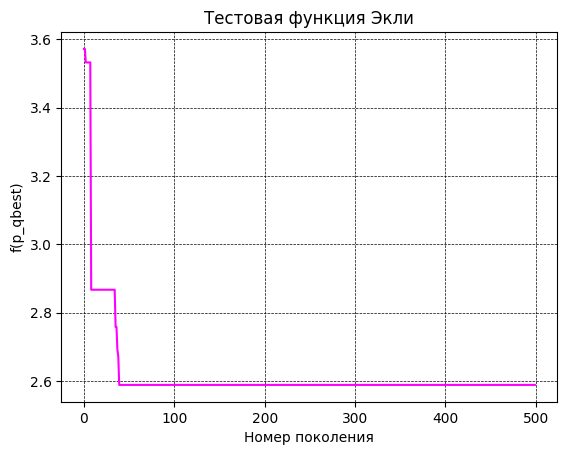

------------------------TEST NUMBER: 6------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.07522928  0.14747024]
The function value of pqbest:		1.0736780467321445
Algorithm running time:			0.04899740219116211 s


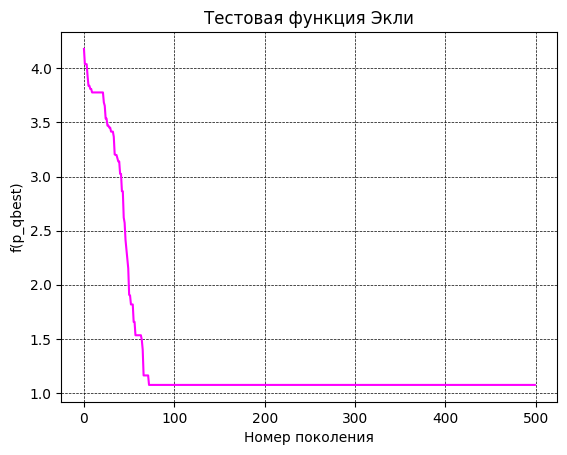

------------------------TEST NUMBER: 7------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[0.00399308 0.00189106]
The function value of pqbest:		0.013016379129489053
Algorithm running time:			0.04898977279663086 s


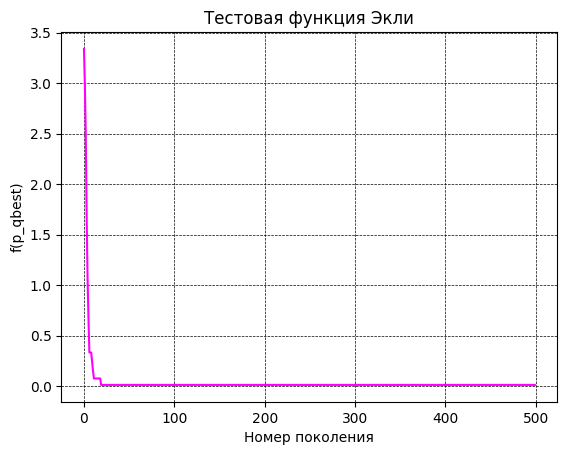

------------------------TEST NUMBER: 8------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.09352924  0.16429538]
The function value of pqbest:		1.2867032093768564
Algorithm running time:			0.048983097076416016 s


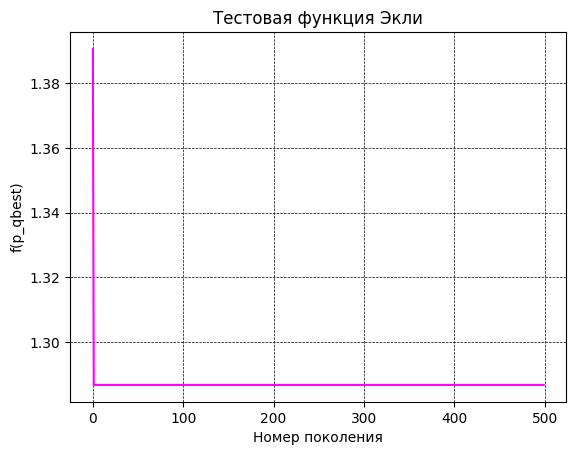

------------------------TEST NUMBER: 9------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[-0.21897543 -0.11416487]
The function value of pqbest:		1.7988811640404165
Algorithm running time:			0.04900312423706055 s


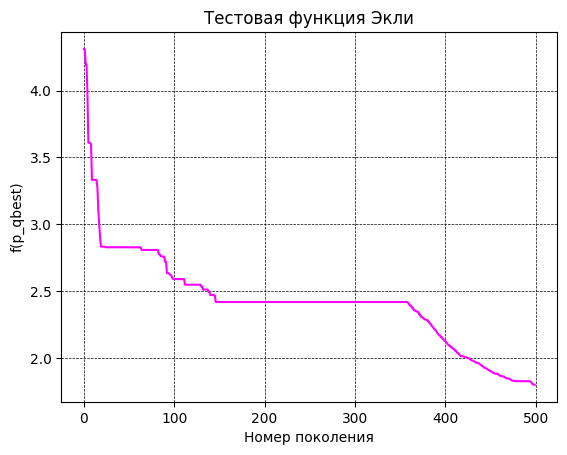

------------------------TEST NUMBER: 10------------------------
Theoretical value (Экли):f(0, 0) = 0

Coordinates of p_qbest:			[ 0.25191565 -0.18207654]
The function value of pqbest:		2.355825736616797
Algorithm running time:			0.04797768592834473 s


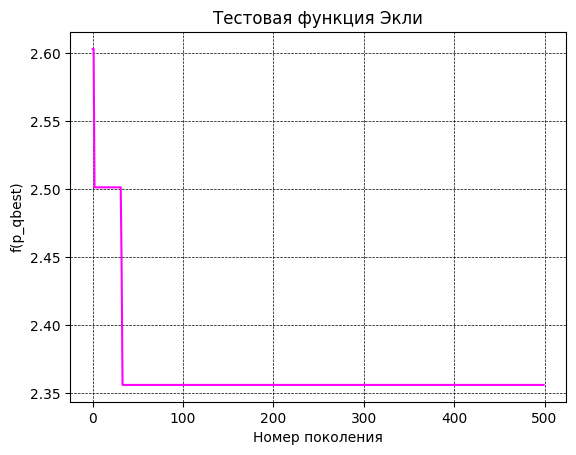

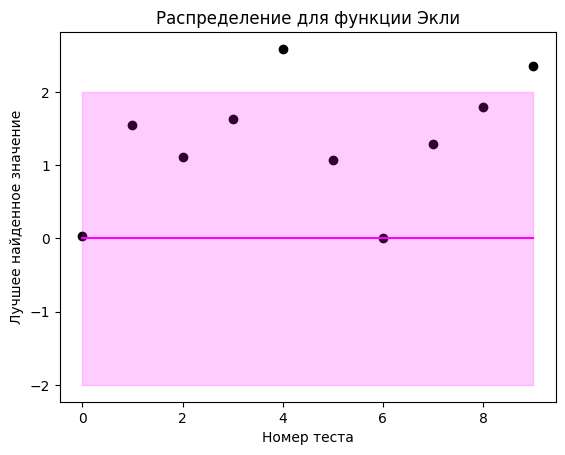

In [35]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(0, 0)")


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [13]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [14]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-1, 1, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.00320226 0.00799762]
The function value of pqbest:		7.421632410888347e-05
Algorithm running time:			3.354956865310669 s


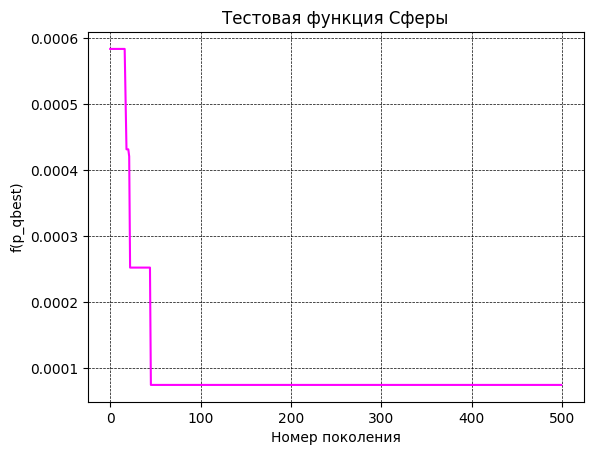

------------------------TEST NUMBER: 2------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[2.66495525e-03 9.04564901e-05]
The function value of pqbest:		7.110168869805577e-06
Algorithm running time:			0.039010047912597656 s


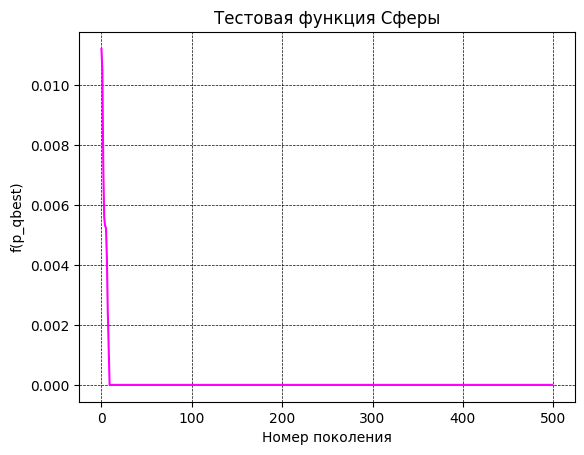

------------------------TEST NUMBER: 3------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.00882635 0.01016875]
The function value of pqbest:		0.00018130798587133047
Algorithm running time:			0.039002418518066406 s


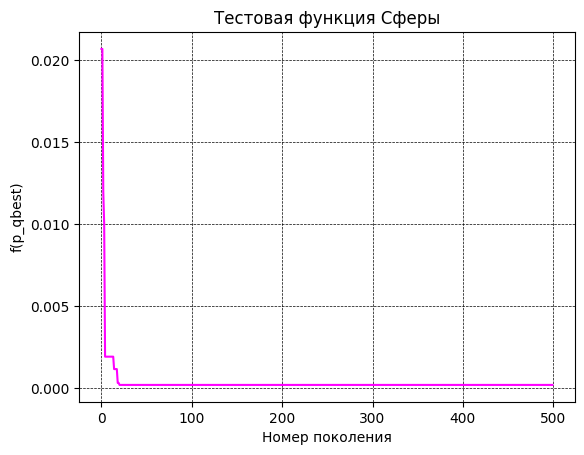

------------------------TEST NUMBER: 4------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.00436906 0.01383861]
The function value of pqbest:		0.00021059584336881345
Algorithm running time:			0.0380096435546875 s


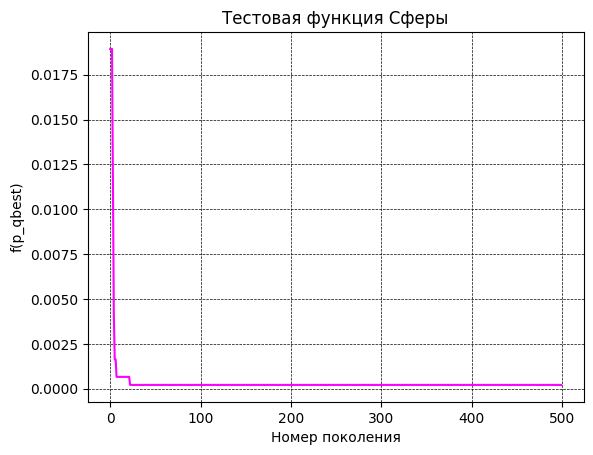

------------------------TEST NUMBER: 5------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.02336634 0.03440742]
The function value of pqbest:		0.0017298568176767916
Algorithm running time:			0.039008378982543945 s


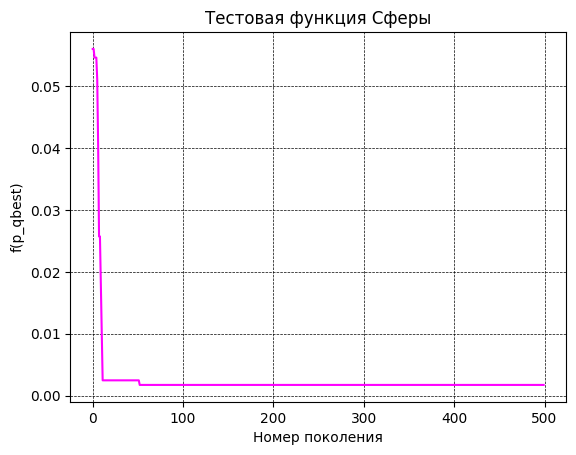

------------------------TEST NUMBER: 6------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.01146211 -0.03862421]
The function value of pqbest:		0.0016232099558430998
Algorithm running time:			0.038011789321899414 s


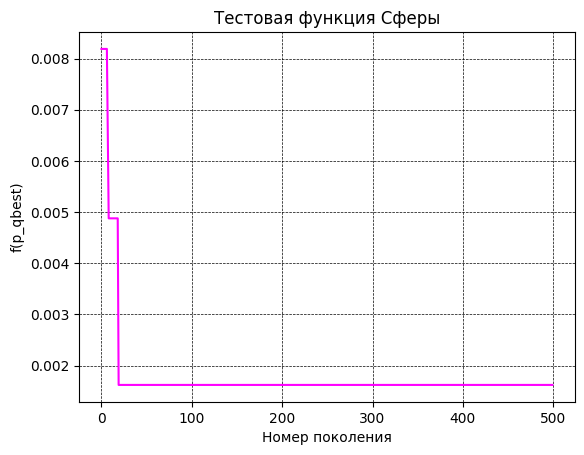

------------------------TEST NUMBER: 7------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[0.00457921 0.00233194]
The function value of pqbest:		2.6407115599056863e-05
Algorithm running time:			0.03897595405578613 s


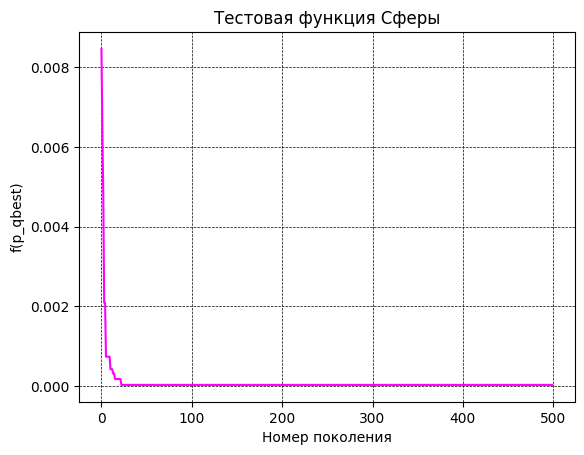

------------------------TEST NUMBER: 8------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.00103506  0.01774382]
The function value of pqbest:		0.00031591461891256284
Algorithm running time:			0.03801083564758301 s


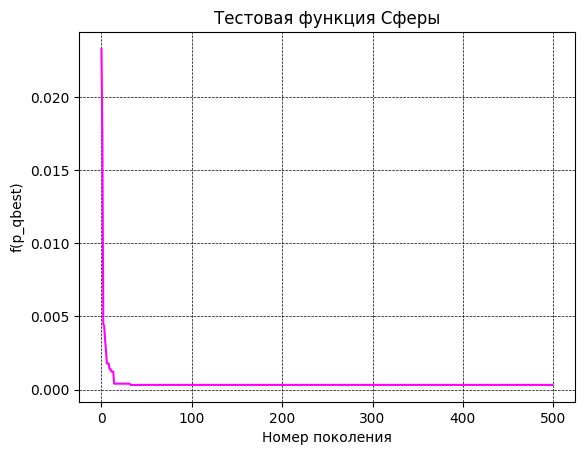

------------------------TEST NUMBER: 9------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.00980223  0.00475448]
The function value of pqbest:		0.00011868885600007442
Algorithm running time:			0.038046836853027344 s


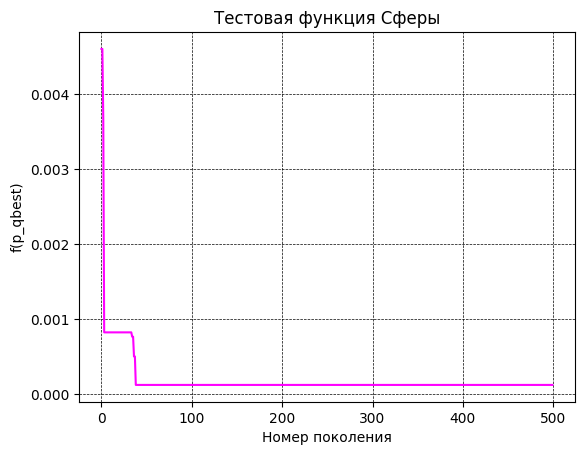

------------------------TEST NUMBER: 10------------------------
Theoretical value (Сферы):f(0, 0..., 0) = 0

Coordinates of p_qbest:			[-0.00112599 -0.00103978]
The function value of pqbest:		2.3489894589480725e-06
Algorithm running time:			0.04203915596008301 s


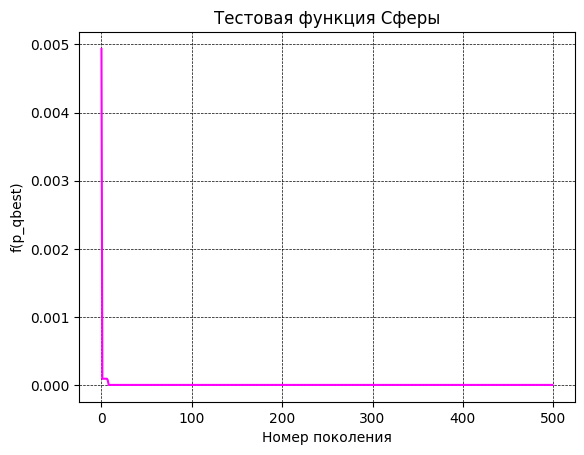

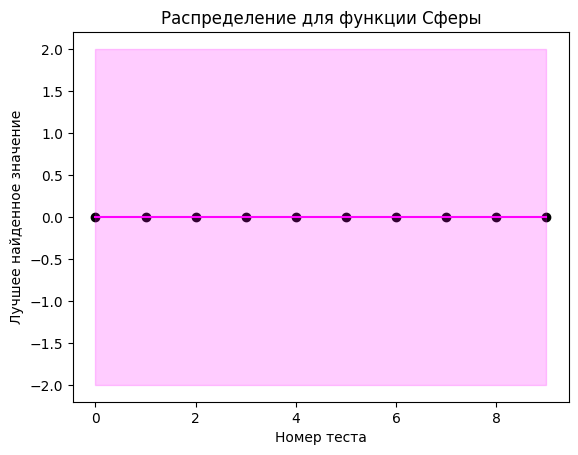

In [15]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенброка
![picture_of_Rosenbrock](src/розенброка.png)

In [16]:
@njit
def f4(x):  # Тестовая функция Розенброка
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [17]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[-0.1023138   0.01733733]
The function value of pqbest:		1.2198143235630012
Algorithm running time:			0.04099678993225098 s


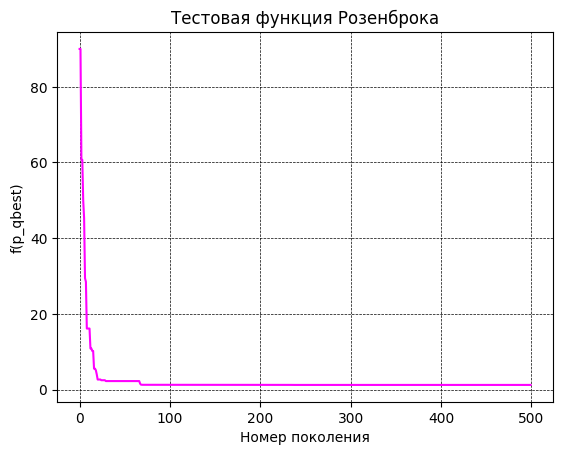

------------------------TEST NUMBER: 2------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[0.56116229 0.27301162]
The function value of pqbest:		0.36806824471214983
Algorithm running time:			0.03898930549621582 s


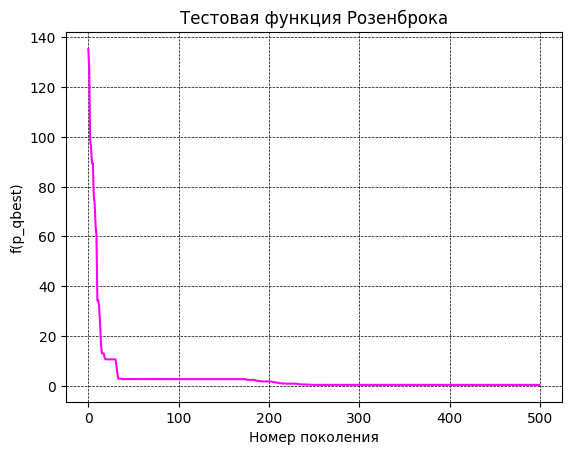

------------------------TEST NUMBER: 3------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[-0.27679893 -0.01699952]
The function value of pqbest:		2.506632964441435
Algorithm running time:			0.039991140365600586 s


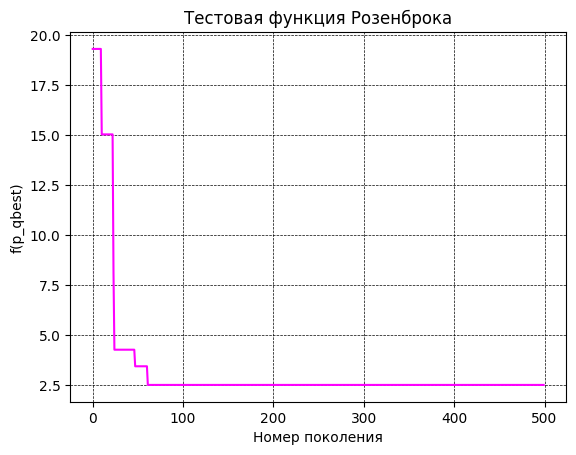

------------------------TEST NUMBER: 4------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[1.10963286 1.23089299]
The function value of pqbest:		0.012034739603036576
Algorithm running time:			0.03799128532409668 s


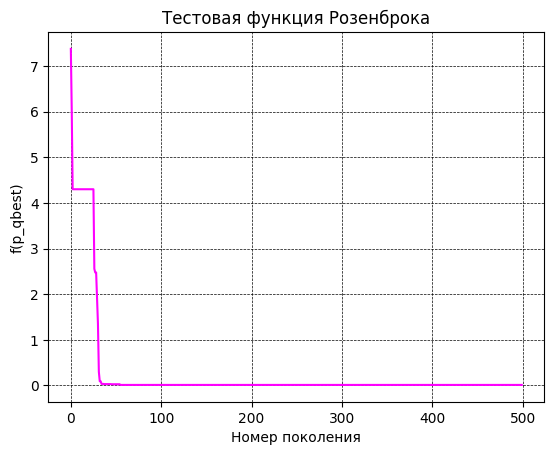

------------------------TEST NUMBER: 5------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[2.17242109 4.71843921]
The function value of pqbest:		1.3746661066905137
Algorithm running time:			0.03800344467163086 s


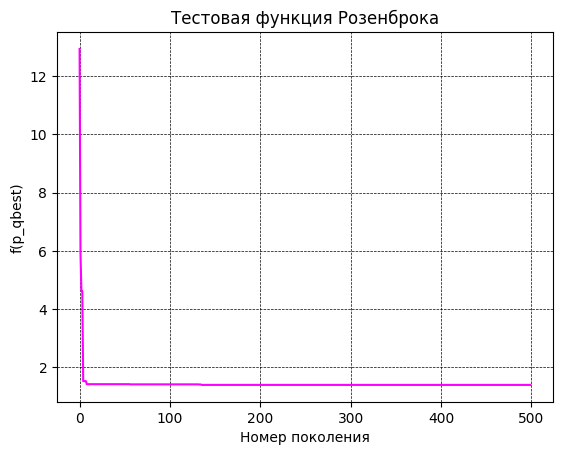

------------------------TEST NUMBER: 6------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[2.77225793 7.82419912]
The function value of pqbest:		5.067028017482805
Algorithm running time:			0.07699108123779297 s


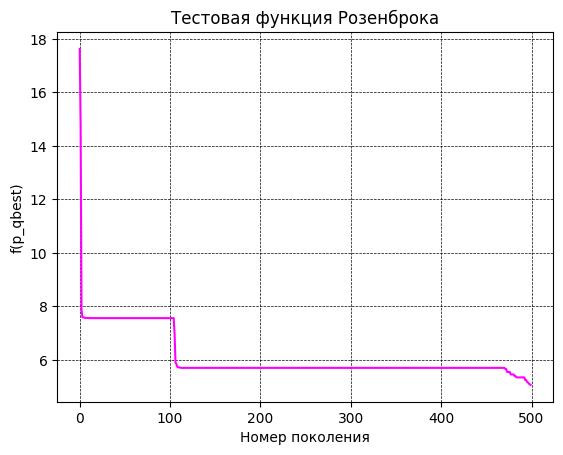

------------------------TEST NUMBER: 7------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[2.19123528 4.80482351]
The function value of pqbest:		1.4201380686301326
Algorithm running time:			0.039999961853027344 s


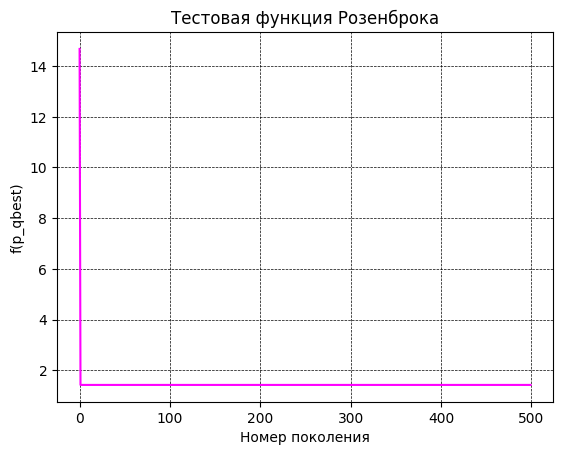

------------------------TEST NUMBER: 8------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[1.03141446 1.06321901]
The function value of pqbest:		0.0010224834992040377
Algorithm running time:			0.03800821304321289 s


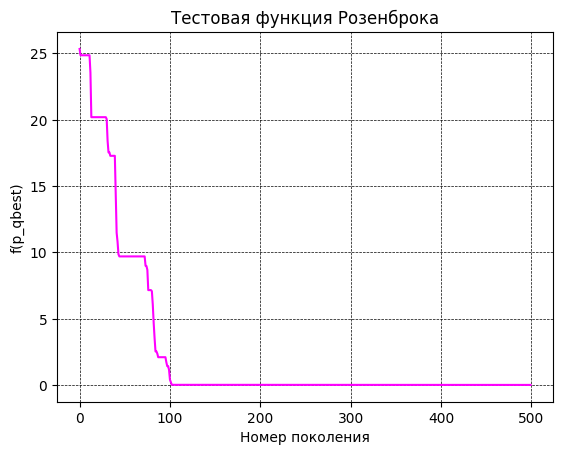

------------------------TEST NUMBER: 9------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[0.75458678 0.56341202]
The function value of pqbest:		0.06381469146355724
Algorithm running time:			0.041997671127319336 s


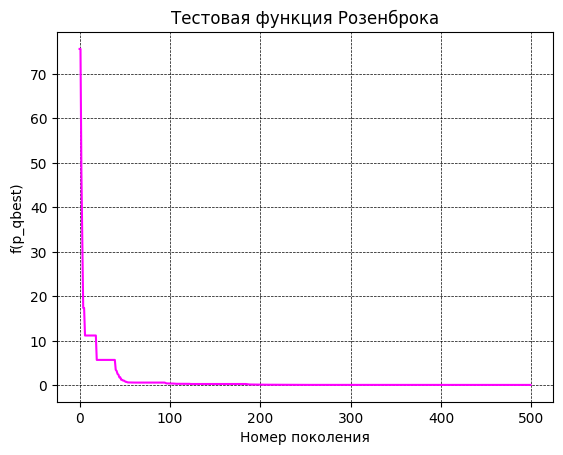

------------------------TEST NUMBER: 10------------------------
Theoretical value (Розенброка):f(1, 1..., 1) = 0

Coordinates of p_qbest:			[ 3.23811196 10.4359375 ]
The function value of pqbest:		5.253492966267929
Algorithm running time:			0.03902411460876465 s


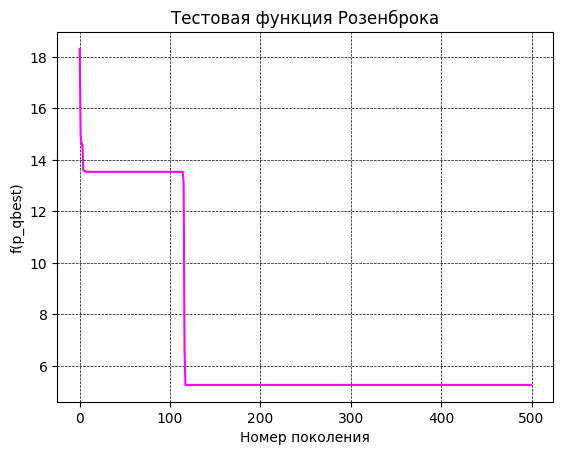

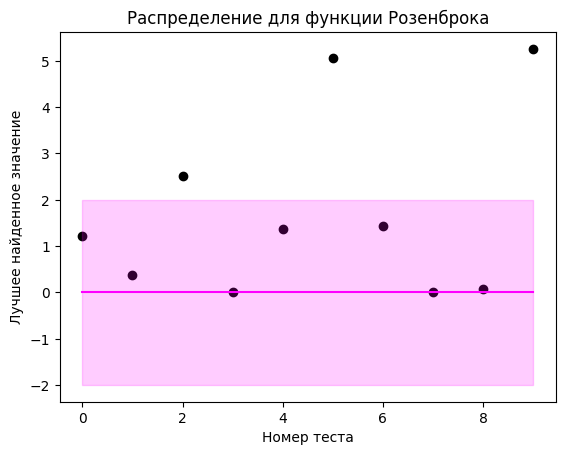

In [37]:
start_test(f4, generate_agents4, "Розенброка", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(1, 1..., 1)")


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [19]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [20]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.27422066 0.56459438]
The function value of pqbest:		0.009506764179261652
Algorithm running time:			3.33001446723938 s


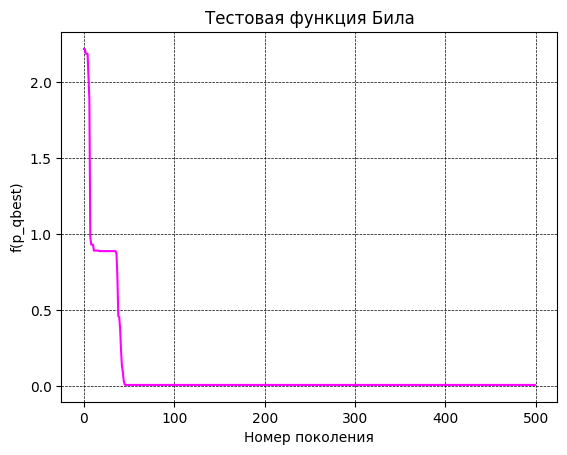

------------------------TEST NUMBER: 2------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.767018   0.44247534]
The function value of pqbest:		0.011975755608654477
Algorithm running time:			0.038019418716430664 s


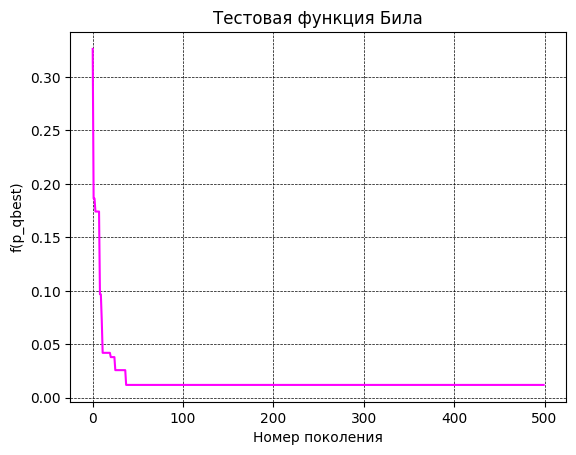

------------------------TEST NUMBER: 3------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.7551879  0.63245407]
The function value of pqbest:		0.046832390801985584
Algorithm running time:			0.039002180099487305 s


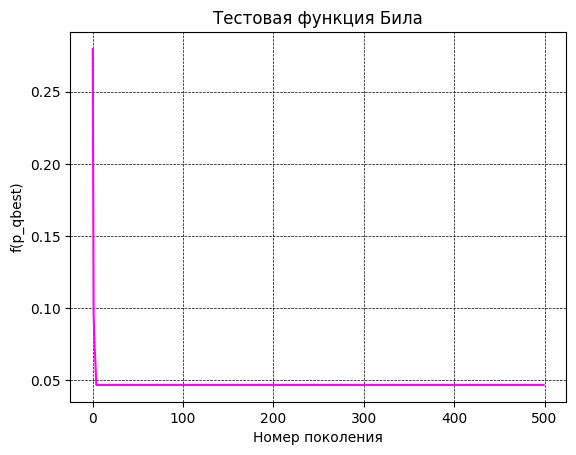

------------------------TEST NUMBER: 4------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.94157377 0.48350045]
The function value of pqbest:		0.0006417686678699634
Algorithm running time:			0.03700375556945801 s


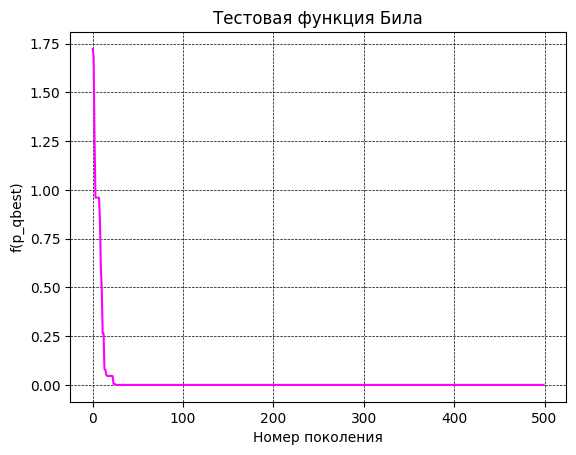

------------------------TEST NUMBER: 5------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.99044033 0.49882507]
The function value of pqbest:		4.789999610470868e-05
Algorithm running time:			0.03899264335632324 s


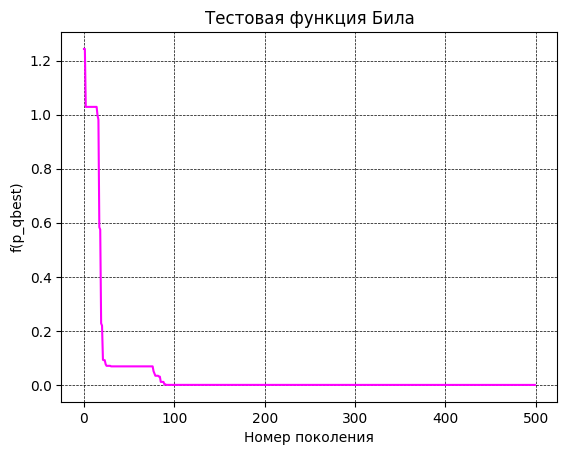

------------------------TEST NUMBER: 6------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.00219225 0.50042675]
The function value of pqbest:		1.080556477525075e-06
Algorithm running time:			0.03899955749511719 s


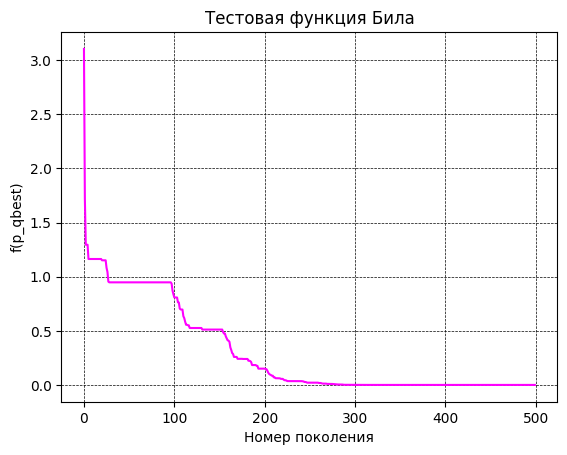

------------------------TEST NUMBER: 7------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.73098403 0.49414444]
The function value of pqbest:		0.09855969125362629
Algorithm running time:			0.03853487968444824 s


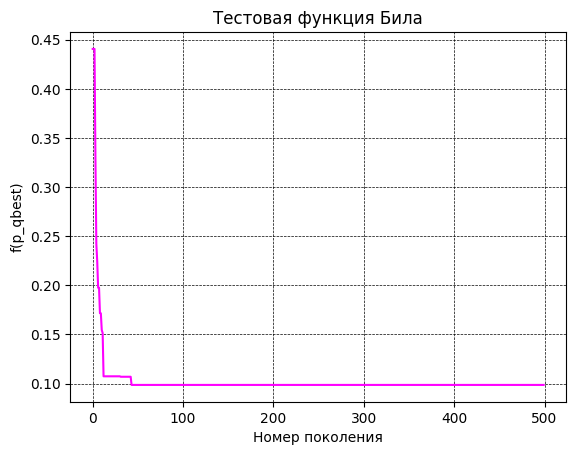

------------------------TEST NUMBER: 8------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.95927225 0.49190379]
The function value of pqbest:		0.0003813590463865236
Algorithm running time:			0.03899335861206055 s


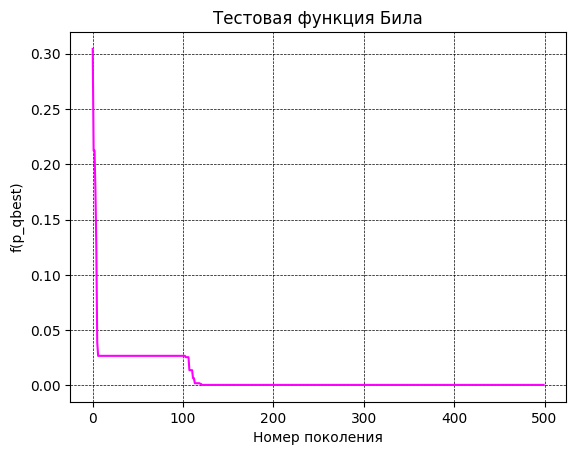

------------------------TEST NUMBER: 9------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[3.77619899 0.63842211]
The function value of pqbest:		0.04671081733548918
Algorithm running time:			0.03900027275085449 s


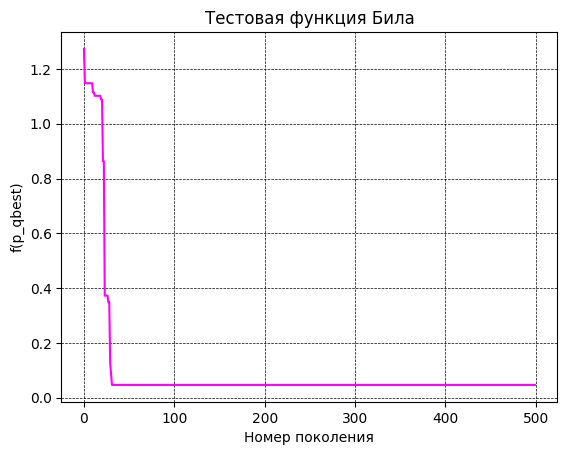

------------------------TEST NUMBER: 10------------------------
Theoretical value (Била):f(3, 0.5) = 0

Coordinates of p_qbest:			[2.83759775 0.45991714]
The function value of pqbest:		0.005244359022535148
Algorithm running time:			0.03799939155578613 s


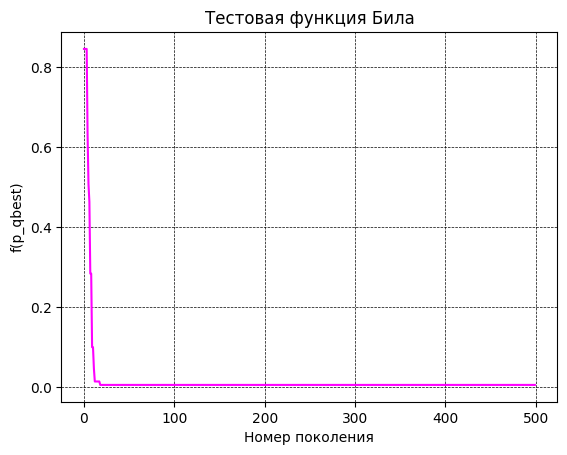

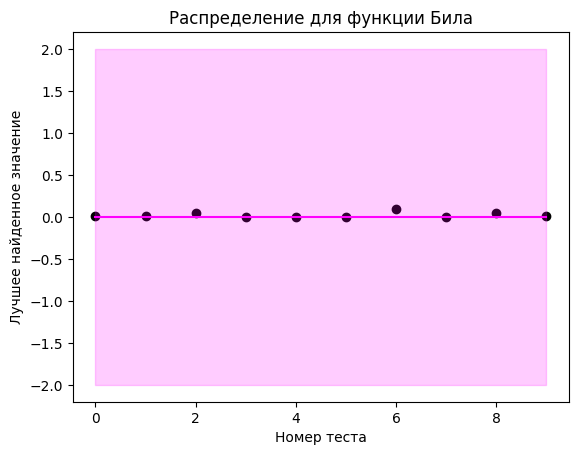

In [21]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(3, 0.5)")

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [22]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [23]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.07392961 -0.92447682]
The function value of pqbest:		7.056823428363574
Algorithm running time:			3.448199987411499 s


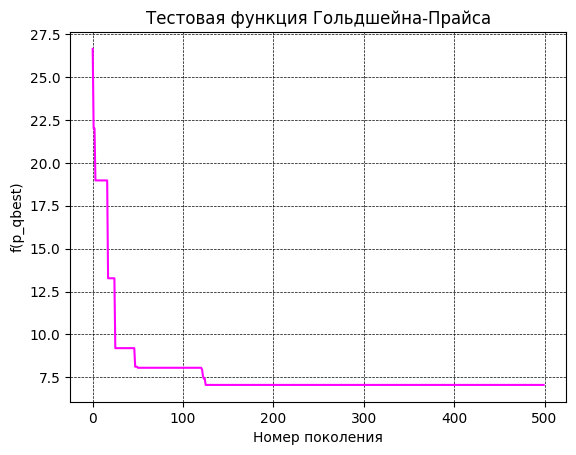

------------------------TEST NUMBER: 2------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.00276647 -0.94821579]
The function value of pqbest:		4.174616080898653
Algorithm running time:			0.03899955749511719 s


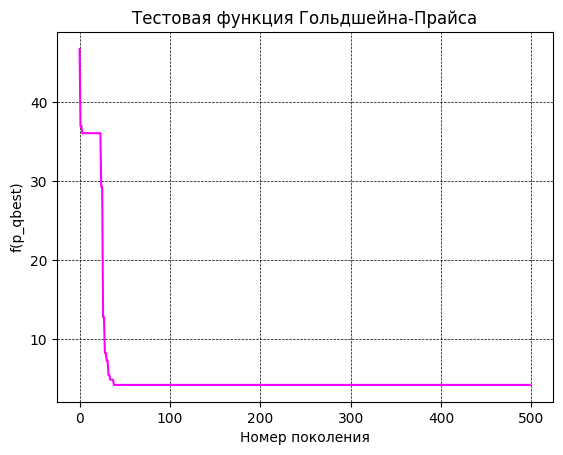

------------------------TEST NUMBER: 3------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.00758072 -1.0029531 ]
The function value of pqbest:		3.013484621536396
Algorithm running time:			0.03800487518310547 s


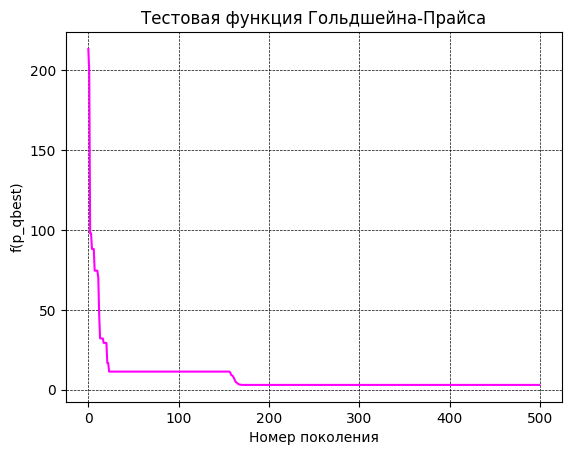

------------------------TEST NUMBER: 4------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.05755164 -0.99529328]
The function value of pqbest:		3.9271997502323845
Algorithm running time:			0.03998398780822754 s


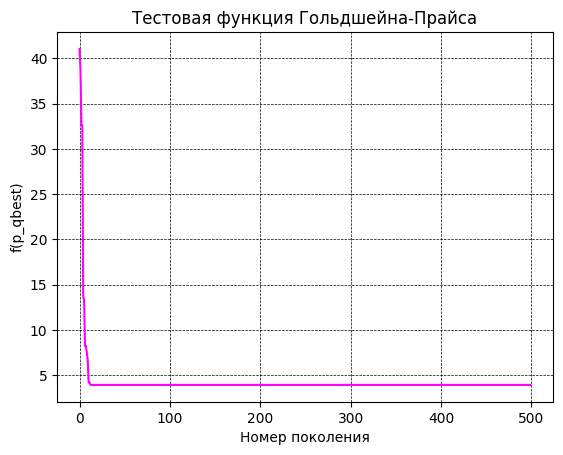

------------------------TEST NUMBER: 5------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.02322019 -0.97316696]
The function value of pqbest:		3.5416206483999826
Algorithm running time:			0.03800249099731445 s


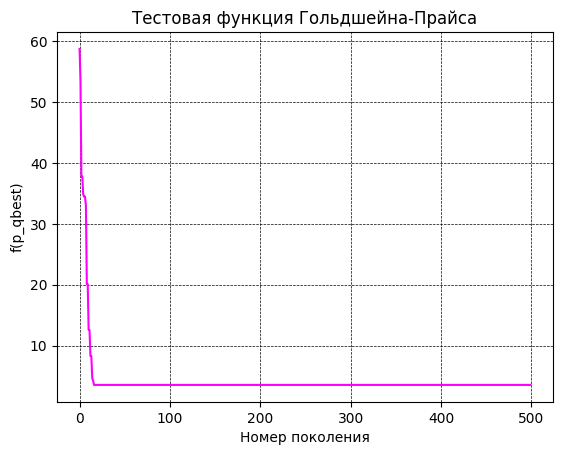

------------------------TEST NUMBER: 6------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.01789442 -0.99068957]
The function value of pqbest:		3.0810190098696633
Algorithm running time:			0.03799319267272949 s


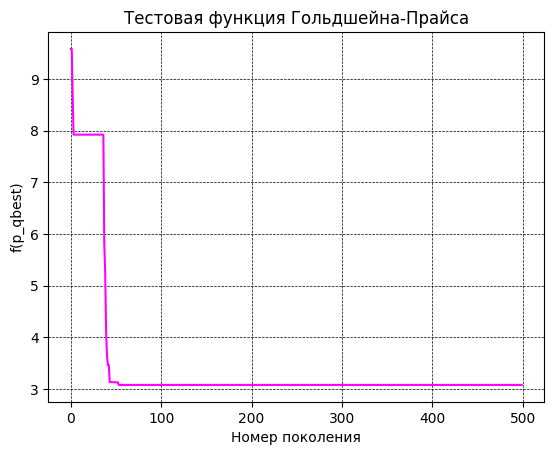

------------------------TEST NUMBER: 7------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.0064993  -1.01995289]
The function value of pqbest:		3.2199140610059502
Algorithm running time:			0.03898477554321289 s


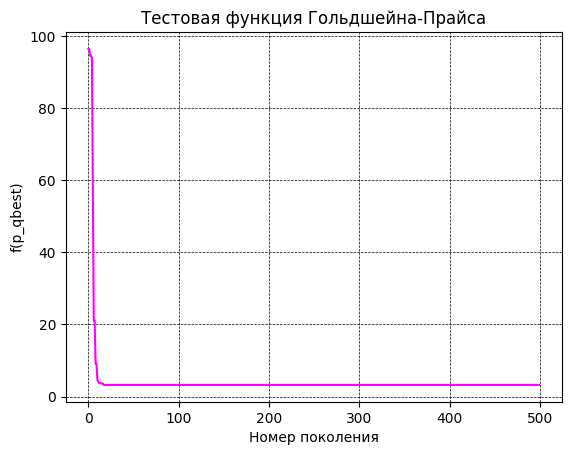

------------------------TEST NUMBER: 8------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.01038873 -1.00658899]
The function value of pqbest:		3.031461728018305
Algorithm running time:			0.038997650146484375 s


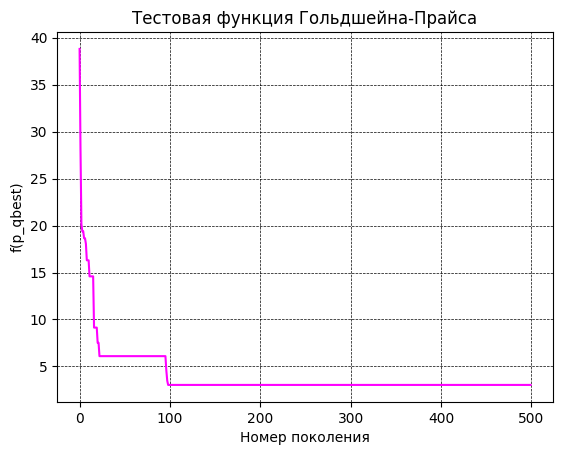

------------------------TEST NUMBER: 9------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[ 0.20680274 -0.84756588]
The function value of pqbest:		14.62569731707124
Algorithm running time:			0.03899812698364258 s


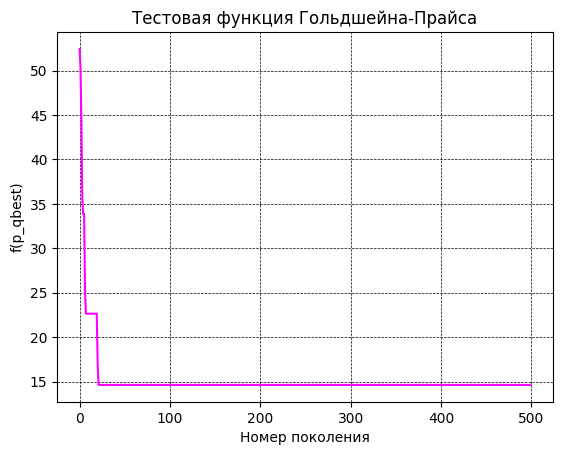

------------------------TEST NUMBER: 10------------------------
Theoretical value (Гольдшейна-Прайса):f(0, -1) = 3

Coordinates of p_qbest:			[-0.02050608 -1.00896096]
The function value of pqbest:		3.102676274291015
Algorithm running time:			0.03901934623718262 s


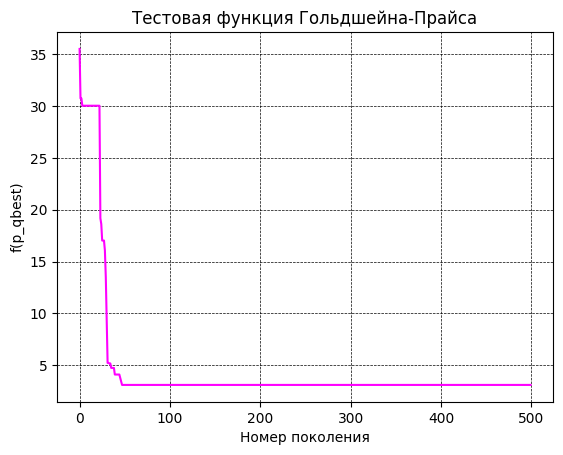

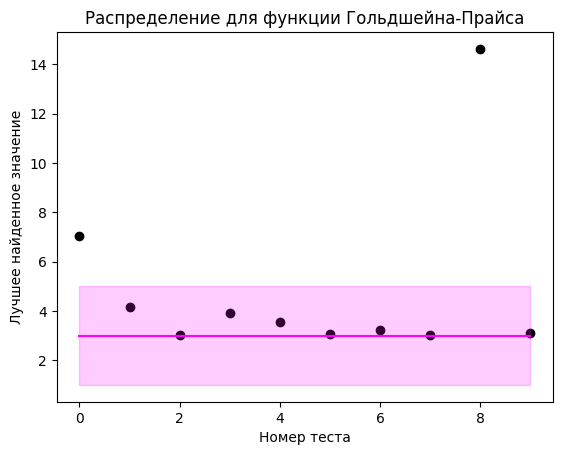

In [24]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3, st="f(0, -1)")

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [25]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [26]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[2.3637697  1.42789686]
The function value of pqbest:		1.3973138235855493
Algorithm running time:			3.1009602546691895 s


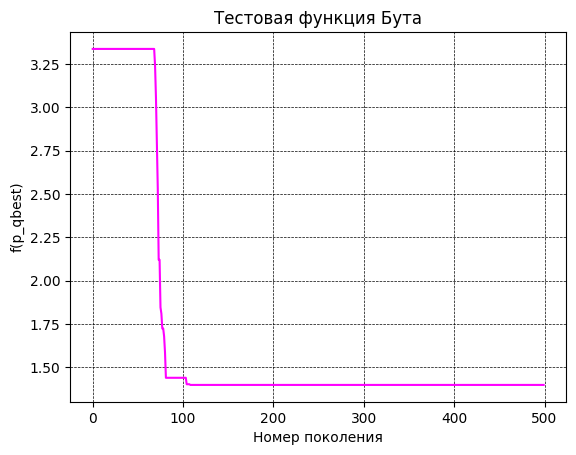

------------------------TEST NUMBER: 2------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.22194108 2.8257245 ]
The function value of pqbest:		0.08157313349707357
Algorithm running time:			0.039000511169433594 s


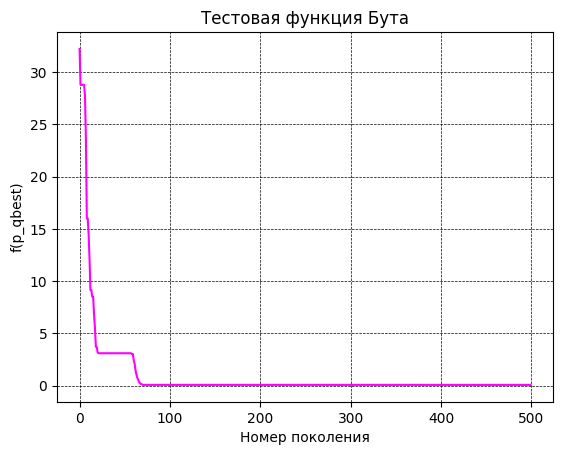

------------------------TEST NUMBER: 3------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.01140355 3.3667955 ]
The function value of pqbest:		0.18774674830017357
Algorithm running time:			0.03798937797546387 s


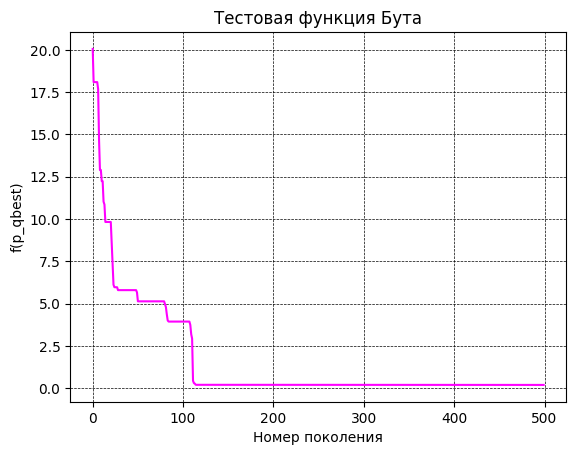

------------------------TEST NUMBER: 4------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.05996793 3.2071097 ]
The function value of pqbest:		0.1474133367502096
Algorithm running time:			0.038010597229003906 s


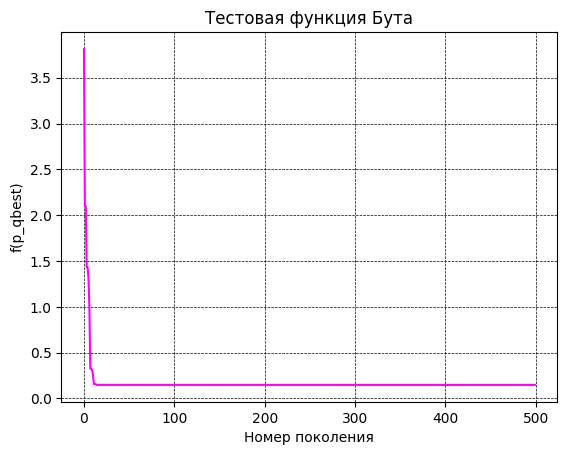

------------------------TEST NUMBER: 5------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[0.86841087 3.91063359]
The function value of pqbest:		0.46243185831393613
Algorithm running time:			0.03699803352355957 s


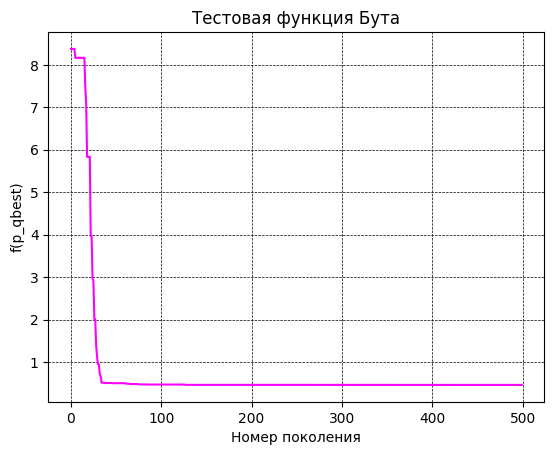

------------------------TEST NUMBER: 6------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[0.66829501 5.15267984]
The function value of pqbest:		2.2306891176093226
Algorithm running time:			0.03799080848693848 s


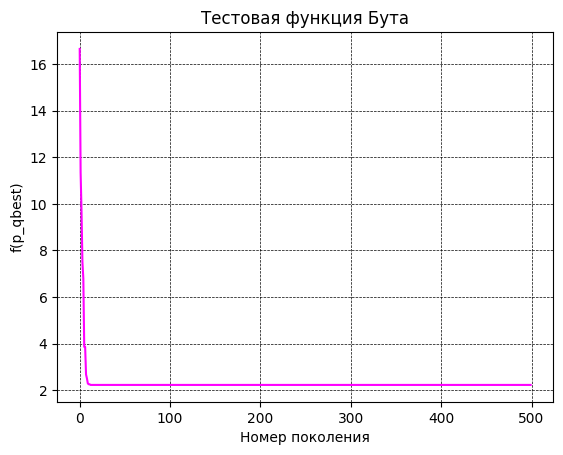

------------------------TEST NUMBER: 7------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[0.64485011 5.25411473]
The function value of pqbest:		2.43343630148923
Algorithm running time:			0.03701043128967285 s


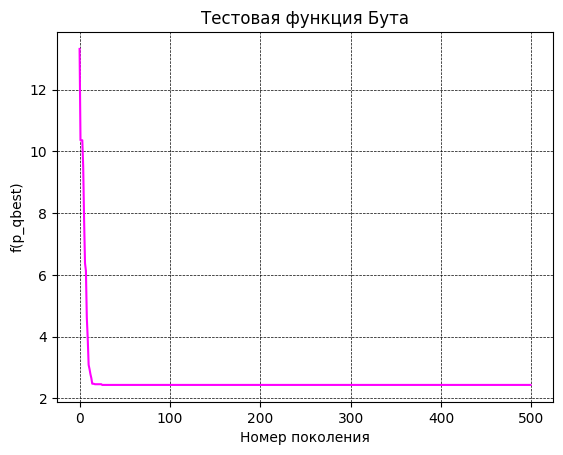

------------------------TEST NUMBER: 8------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.12589189 3.0539433 ]
The function value of pqbest:		0.10864236217952382
Algorithm running time:			0.039000511169433594 s


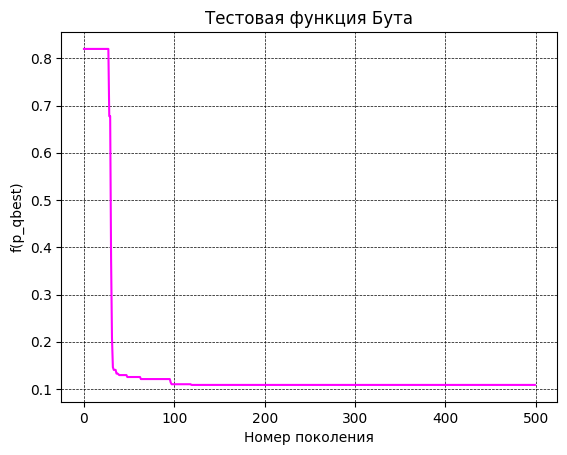

------------------------TEST NUMBER: 9------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.22326605 2.81823968]
The function value of pqbest:		0.08114719546708936
Algorithm running time:			0.037988901138305664 s


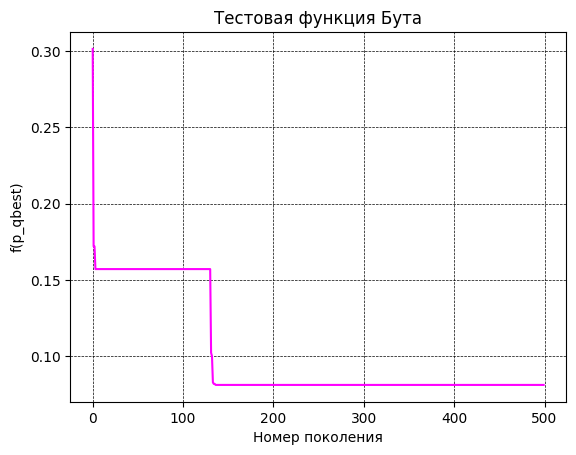

------------------------TEST NUMBER: 10------------------------
Theoretical value (Бута):f(1, 3) = 0

Coordinates of p_qbest:			[1.1477364  2.96156561]
The function value of pqbest:		0.10679468270195175
Algorithm running time:			0.038010358810424805 s


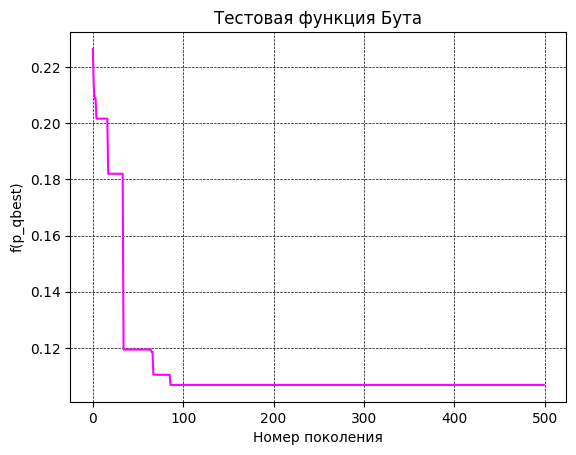

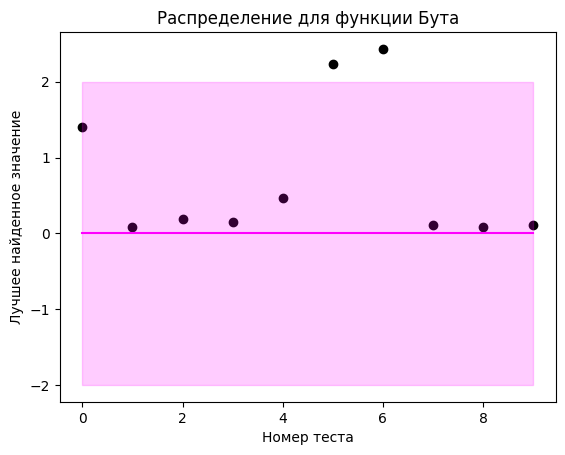

In [27]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_, st="f(1, 3)")

## Реализация алгоритма на C. Сравнение двух реализаций

In [28]:
import ctypes
import os


class Result(ctypes.Structure):
    _fields_ = [
        ("best_solution", ctypes.POINTER(ctypes.c_float)),
        ("best_y", ctypes.c_float),
        ("time_spent", ctypes.c_double)
    ]


def c(file, name, types, result):
    path = os.path.abspath(file)
    module = ctypes.cdll.LoadLibrary(path)
    func = module[name]
    func.argtypes = types
    func.restype = result
    return func


test_Rastrigen = c("libcode.dll", "test_Rastrigen", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Ekli = c("libcode.dll", "test_Ekli", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Sphere = c("libcode.dll", "test_Sphere", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Rosenbock = c("libcode.dll", "test_Rosenbock", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Bila = c("libcode.dll", "test_Bila", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Goldsheina_Praisa = c("libcode.dll", "test_Goldsheina_Praisa", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Buta = c("libcode.dll", "test_Buta", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)


## Сравнение реализаций по скорости выполнения

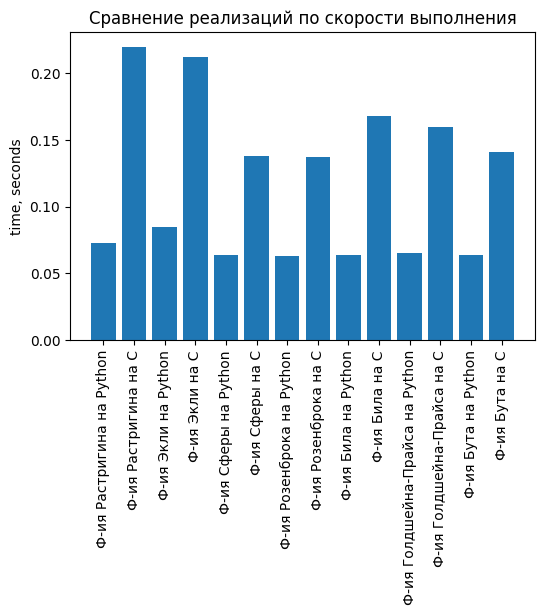

In [233]:
time_on_c = list()
time_on_c.append(test_Rastrigen(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Ekli(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Sphere(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Rosenbock(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Bila(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Goldsheina_Praisa(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Buta(number_of_agents_, n_args_count_, iter_max_).time_spent)

time_on_python = list()
start = time.time()
main_function(f1, generate_agents1, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f2, generate_agents2, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f3, generate_agents3, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f4, generate_agents4, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f5, generate_agents5, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f6, generate_agents6, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f7, generate_agents7, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)

plt.rcParams['axes.grid'] = False
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

list_to_draw = list()
for i in range(7):
    list_to_draw.append(time_on_python[i])
    list_to_draw.append(time_on_c[i])

list_of_title = ['Ф-ия Растригина на Python', 'Ф-ия Растригина на C',
                 'Ф-ия Экли на Python', 'Ф-ия Экли на C',
                 'Ф-ия Сферы на Python', 'Ф-ия Сферы на C',
                 'Ф-ия Розенброка на Python', 'Ф-ия Розенброка на С',
                 'Ф-ия Била на Python', 'Ф-ия Била на C',
                 'Ф-ия Голдшейна-Прайса на Python', 'Ф-ия Голдшейна-Прайса на C',
                 'Ф-ия Бута на Python', 'Ф-ия Бута на C']

ax.bar(list_of_title, list_to_draw)

plt.ylabel("time, seconds")
plt.title("Сравнение реализаций по скорости выполнения")
plt.xticks(rotation=90)
plt.show()

## Тестирование алгоритма в n-мерном пространстве

### Тестирование алгоритма в 100-мерном пространстве

In [97]:
start = time.time()
res = main_function(f3, generate_agents3, 100, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 7.83839999808262
Time is 8.546939849853516
Coordinates: [-0.01461523  0.40158649  0.29920827  0.30797507  0.34206651 -0.04727888
  0.09802692  0.19218935  0.07653566  0.23741665  0.35784918  0.3228778
  0.27096489  0.270692    0.25549173  0.27041753  0.35627098  0.36671147
  0.27289764  0.2192784   0.45376702  0.28108338  0.31843085  0.31257644
  0.0883634   0.30700201  0.13706985  0.29467947  0.23952454  0.21272725
  0.31801226  0.29503359  0.26212068  0.23302186  0.36577441  0.32642406
 -0.13128564  0.33567763  0.30697849  0.26504323  0.28867557  0.30999928
  0.28652184  0.27279779  0.22347787  0.19455194  0.29695399  0.24264899
  0.28002313 -0.14555896  0.22976996  0.28262078  0.25661435  0.23432025
  0.22668165  0.37574783  0.34671453  0.24648158  0.18093782  0.26043426
  0.46004987  0.29312847  0.20543473  0.32597006  0.05233861  0.22697023
  0.11470339  0.32749406  0.26887365  0.24685598  0.29681687 -0.07245868
  0.2893826  -0.

### Тестирование алгоритма в 50-мерном пространстве

In [101]:
start = time.time()
res = main_function(f3, generate_agents3, 50, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 4.011107057377971
Time is 7.233178615570068
Coordinates: [ 0.26751926  0.36184321  0.08937083  0.30431897  0.06145001  0.21911876
 -0.05789606  0.06782827  0.2829966   0.3084018   0.04798901  0.23651979
 -0.04983506  0.14379761  0.31060685  0.28856066  0.12289851  0.27201303
  0.10605441  0.26878344  0.35632883  0.41057165  0.28069547  0.03132403
  0.32765322  0.38909472  0.37330137  0.24458449  0.7508708   0.08396954
  0.25386361  0.43418145  0.19761023  0.28513771 -0.20811839  0.32759267
 -0.23136397  0.27151275  0.24562856  0.31652302  0.3053794   0.3888473
  0.18432334  0.0922668   0.20388972  0.18155134  0.62805986  0.01524695
  0.10535608  0.23718616]


### Тестирование алгоритма в 10-мерном пространстве

In [99]:
start = time.time()
res = main_function(f3, generate_agents3, 10, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 0.1497749230017234
Time is 5.715345144271851
Coordinates: [ 0.01720229  0.09220778 -0.06618106  0.11334128  0.04333773  0.25308036
  0.14630737  0.09779017  0.15358089 -0.05715654]
